<a href="https://colab.research.google.com/github/rubyvanrooyen/ARIWS-Cookbook/blob/main/1-Fundamentals_of_radio_astronomy/MeerKAT_UV_coverage_with_Astropy_and_CASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

The basic unit of an interferometer array is the single baseline between two (2) antennas.

$|B> = (B_x, B_y, B_z) = (x_1-x_0, y_1-y_0, z_1-z_0)$ and    
$|B| = \sqrt{B_x^2 + B_y^2 + B_z^2}$

The vector difference in position can point in any direction on the sky, but the baseline direction that matters when calculating `UV` is the component perpendicular to the phase center direction $B_{proj}$.

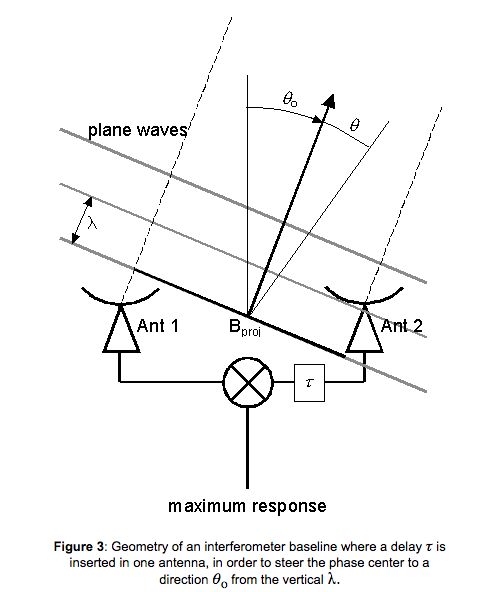
Only when the source is at zenith (directly above) the plane wave (signal) reach both dishes simultaneously. A plane wave arriving from any other angle will reach one dish before the other. To compensate for this late arrival, a delay is added into the signal path of the one antenna.  A delay in time domain is the same as a phase offset in the Fourier domain, which effectively "steer" the phase center, $\theta_0$. Thus "pointing" the antennas to the source located at position ($\alpha$, $\delta$) relative to the phase center along the projected distance between antennas not the distance along the ground    
Reference: https://web.njit.edu/~gary/728/Lecture6.html

A delay, $\tau$, must be inserted in the signal path of one of the antennas to "steer" the baseline direction to point in the direction of a source.
This is commonly called steering the baseline in the direction of the phase center.

Conceptually, applying this delay to "point" the projected baseline, $B_{proj}$, in the direction of the source ensures both antennas measure the plane wave coming from the source at the same point in time (in other words the signals are in phase).

The `UV` plane is always perpendicular to the direction of the phase center (the source).
The `U` and `V` coordinates describe the E-W and N-S components of the projected baseline, with `U` pointing towards East (rising) and `V` pointing towards the celestial pole.
`W` points to and follows the source phase tracking center and thus represents the delay distance, $\tau$, between the two antennas.

The baseline now becomes $|B> = \lambda (U, V, W)$ in units of wavelength.

# Import libraries

In [1]:
from astropy.coordinates import ICRS, GCRS, SkyCoord
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
from datetime import datetime, timedelta

import astropy
import astropy.time
import astropy.units as u
import numpy as np

## Do this to get updated IERS B values into astropy

In [2]:
from astropy.utils import iers
from astropy.utils import data
iers_b = iers.IERS_B.open(data.download_file(iers.IERS_B_URL, cache=True))
iers_auto = iers.IERS_Auto.open()

# Define target and time of observation

In [3]:
# J1939-6342
# https://docs.astropy.org/en/stable/coordinates/index.html
target = SkyCoord('19h39m25.0264s', '-63d42m45.624s', frame='icrs')
obs_time = datetime(2013, 6, 21, 21)
# https://docs.astropy.org/en/stable/api/astropy.time.Time.html
obs_time = astropy.time.Time(obs_time, format='datetime', scale='utc')

# MeerKAT

The antenna locations as measured using theodelite can be found in the ARIWS cookbook:    
https://github.com/ska-sa/ARIWS-Cookbook/tree/main/data   
More accurate antenna locations can be found in the MeerKAT observation data itself.

Antenna positions and pointing models are part of the MeerKAT meta-data accompanying all observations.   
See MeerKAT Cookbook for information:   
https://github.com/ska-sa/MeerKAT-Cookbook

Specifically the notebook:    
https://github.com/ska-sa/MeerKAT-Cookbook/blob/master/katdal/Explaining%20MeerKAT%20array%20information.ipynb

In [4]:
"""General Earth position for the Telescope"""
# reference position is given in geodetic coordinates (lat, lon, height)
# convert to geocentric coordinates (x, y, z)
telescope = EarthLocation.from_geodetic(Longitude('21:26:38.0', u.degree, wrap_angle=180. * u.degree, copy=False),
                                        Latitude('-30:42:39.8', u.degree, copy=False),
                                        height=u.Quantity(1086.6, u.m, copy=False))
print(f'Telescope MKT {telescope}')
[ref_x, ref_y, ref_z] = telescope.geocentric

# MeerKAT antenna positions (E, N, U) offset from telescope reference location
antpos = np.array([[-8.264, -207.29, 8.5965],  # m000
                   [1.1205, -171.762, 8.4705],  # m001
                   [-32.113, -224.236, 8.6445],  # m002
                   [-66.518, -202.276, 8.285],  # m003
                   [-123.624, -252.946, 8.513],  # m004
                   [-102.088, -283.12, 8.875],  # m005
                   [-18.2315, -295.428, 9.188],  # m006
                   [-89.592, -402.732, 9.7685],  # m007
                   [-93.527, -535.026, 10.4445],  # m008
                   [32.3565, -371.0555, 10.14],  # m009
                   [88.095, -511.872, 11.1855],  # m010
                   [84.0115, -352.078, 10.151],  # m011
                   [140.019, -368.267, 10.4485],  # m012
                   [236.7915, -393.46, 11.124],  # m013
                   [280.669, -285.792, 10.5465],  # m014
                   [210.6435, -219.1415, 9.738],  # m015
                   [288.159, -185.873, 9.795],  # m016
                   [199.6235, -112.263, 8.9545],  # m017
                   [105.7265, -245.8695, 9.529],  # m018
                   [170.7865, -285.223, 10.0705],  # m019
                   [97.016, -299.638, 9.8765],  # m020
                   [-295.9655, -327.241, 8.117],  # m021
                   [-373.0015, 0.544, 5.649],  # m022
                   [-322.306, -142.1845, 6.8245],  # m023
                   [-351.0455, 150.088, 4.845],  # m024
                   [-181.9775, 225.617, 5.068],  # m025
                   [-99.0035, 17.045, 6.811],  # m026
                   [40.4745, -23.112, 7.694],  # m027
                   [-51.179, -87.17, 7.6355],  # m028
                   [-88.7615, -124.111, 7.6995],  # m029
                   [171.2805, 113.949, 7.278],  # m030
                   [246.5665, 93.756, 7.4685],  # m031
                   [461.2745, 175.505, 7.367],  # m032
                   [580.678, 863.9585, 3.5995],  # m033
                   [357.8105, -28.308, 8.972],  # m034
                   [386.152, -180.8935, 10.2895],  # m035
                   [388.2565, -290.759, 10.812],  # m036
                   [380.2855, -459.3085, 12.1715],  # m037
                   [213.308, -569.08, 11.946],  # m038
                   [253.7475, -592.1465, 12.441],  # m039
                   [-26.858, -712.219, 11.8325],  # m040
                   [-287.545, -661.678, 9.9485],  # m041
                   [-361.7135, -460.318, 8.497],  # m042
                   [-629.8525, -128.326, 5.264],  # m043
                   [-896.164, 600.4965, -0.6395],  # m044
                   [-1832.8595, 266.75, 0.1075],  # m045
                   [-1467.341, 1751.923, -7.0775],  # m046
                   [-578.2955, -517.2965, 7.6145],  # m047
                   [-2805.653, 2686.863, -9.7545],  # m048
                   [-3605.9565, 436.462, 2.696],  # m049
                   [-2052.336, -843.7145, 5.3375],  # m050
                   [-850.255, -769.359, 7.6135],  # m051
                   [-593.192, -1148.652, 10.55],  # m052
                   [9.3645, -1304.462, 15.032],  # m053
                   [871.9795, -499.812, 13.3635],  # m054
                   [1201.7795, 96.492, 10.0225],  # m055
                   [1598.4025, 466.6675, 6.99],  # m056
                   [294.6445, 3259.9145, -10.6365],  # m057
                   [2805.764, 2686.873, -3.6595],  # m058
                   [3686.4265, 758.895, 11.8215],  # m059
                   [3419.6825, -1840.478, 23.6965],  # m060
                   [-16.4085, -2323.779, 21.304],  # m061
                   [-1440.6315, -2503.773, 21.6825],  # m062
                   [-3419.5845, -1840.48, 16.3825],  # m063
                   ]) * u.m

L = Latitude('-30:42:39.8', u.degree, copy=False)
L_sin = np.sin(L.rad)
L_cos = np.cos(L.rad)
x = -L_sin * antpos[:,1] + L_cos * antpos[:,2]
y = antpos[:,0]
z = L_cos * antpos[:,1] + L_sin * antpos[:,2]

# Format antenna positions
antpos=np.array([ref_x+x, ref_y+y, ref_z+z]).T * u.m

Telescope MKT (5109360.13332123, 2006852.58604291, -3238948.12747888) m


# Astropy Implementation
Calculating `UV` coverage pointing to a target using Astropy.
The `UV` plane is always perpendicular to the direction of the phase center (the direction of the source).
The spatial sampling of the source brightness distribution is indicated by what baselines are recorded and their orientation w.r.t. the sky.

Reference: [Interferometric UVW calculation using astropy](https://gist.github.com/demorest/8c8bca4ac5860796593ca07006cc3df6)

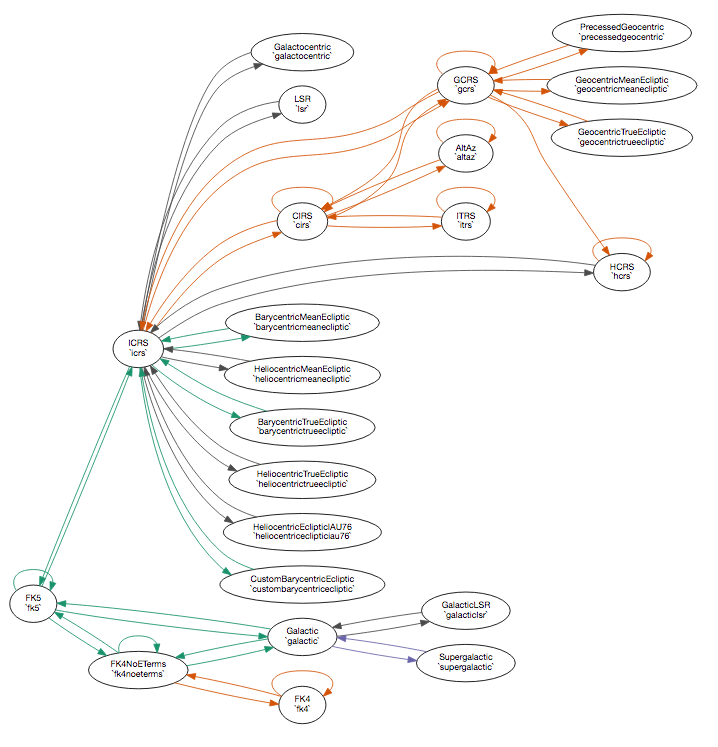
Astropy coordinate systems    
Reference: https://docs.astropy.org/en/stable/coordinates


## Algorithm
Each baseline of a synthesis radio array measures a point in the `UV` plane.
As the source moves across the sky -- rising in the East and setting in the West -- it is tracked by adjusting the phase centre delay to ensure each projected baseline continuous to point at the source target.

Tracking the target over time, fills in the `UV` plane.
In astronomy, the hour angle ($H_a$) describes the track of a source on the sky over time.


$\left[
\begin{array}{r}
U \\ V \\ W \\
\end{array}
\right]
=
\left[
\begin{array}{rcl}
\sin(Ha) & \cos(Ha) & 0 \\
-\sin(\delta)\cos(Ha) & \sin(\delta)\sin(Ha) & \cos(\delta) \\
\cos(\delta)\cos(Ha) & -\cos(\delta)\sin(Ha) & \sin(\delta) \\
\end{array}
\right]
\left[
\begin{array}{r}
x \\ y \\ z \\
\end{array}
\right]$


1.   Antenna positions and Telescope location as `EarthLocation`    
Format antenna positions and telescope reference position as EarthLocation.    
Antenna positions are measured in terms of meters along the ground.    
These coordinates are relative to the local horizon and depends on the telescope's reference position on the spherical Earth.    
Need to rotate the terrestrial coordinates relative to the telescope location to be aligned with the Earth's rotational axis.


In [5]:
# MeerKAT antenna positions, ITRF, m
ap_T_pos = EarthLocation(x=antpos[:,0], y=antpos[:,1], z=antpos[:,2])

In [6]:
print(f'Observe target {target} at date-time {obs_time.datetime}')
print(f'Telescope {telescope}')
print(f'AP position ITRS [m] {ap_T_pos}')

Observe target <SkyCoord (ICRS): (ra, dec) in deg
    (294.85427667, -63.71267333)> at date-time 2013-06-21 21:00:00
Telescope (5109360.13332123, 2006852.58604291, -3238948.12747888) m
AP position ITRS [m] [(5109261.65936259, 2006844.32204291, -3239130.73614072)
 (5109279.69549664, 2006853.70654291, -3239100.12646042)
 (5109253.04615907, 2006820.47304291, -3239145.33004168)
 (5109263.95224333, 2006786.06804291, -3239126.26624966)
 (5109238.27065118, 2006728.96204291, -3239169.94641344)
 (5109223.17175404, 2006750.49804291, -3239196.07349949)
 (5109217.15505278, 2006834.35454291, -3239206.81520042)
 (5109162.8530404 , 2006762.99404291, -3239299.36668257)
 (5109095.87052105, 2006759.05904291, -3239413.45218346)
 (5109179.34990692, 2006884.94254291, -3239272.32242145)
 (5109108.33255063, 2006940.68104291, -3239393.92388052)
 (5109189.05134088, 2006936.59754291, -3239256.01206258)
 (5109181.0392525 , 2006992.60504291, -3239270.0825518 )
 (5109168.7537288 , 2007089.37754291, -3239292.087311

2.  Convert antenna pos terrestrial to celestial.    
For astropy use `get_gcrs_posvel(t)[0]` rather than `get_gcrs(t)` because if a velocity is attached to the coordinate astropy will not allow us to do additional transformations with it (https://github.com/astropy/astropy/issues/6280)


In [7]:
# for each pointing
# The GCRS position of the object
# The GCRS velocity of the object
tel_p, tel_v = telescope.get_gcrs_posvel(obs_time)  # CartesianRepresentation
ant_p, ant_v = ap_T_pos.get_gcrs_posvel(obs_time)
ap_C_pos = GCRS(ant_p, obstime=obs_time, obsgeoloc=tel_p, obsgeovel=tel_v)
print(f'AP position GCRS {ap_C_pos}')

AP position GCRS <GCRS Coordinate (obstime=2013-06-21 21:00:00, obsgeoloc=(-2194350.94627562, -5033442.1045704, -3236215.03474284) m, obsgeovel=(367.0527983, -159.70007957, -0.49488389) m / s): (ra, dec, distance) in (deg, deg, m)
    [(246.44528876, -30.51569924, 6373691.76871301),
     (246.44531165, -30.51536992, 6373693.6257962 ),
     (246.44508968, -30.51588844, 6373684.77176592),
     (246.44471414, -30.51575147, 6373672.99328203),
     (246.44425656, -30.51629365, 6373656.62513572),
     (246.44452295, -30.5165245 , 6373664.5803461 ),
     (246.44536041, -30.51649422, 6373691.61912468),
     (246.4448727 , -30.51756025, 6373672.65869044),
     (246.44508805, -30.51873517, 6373675.70946413),
     (246.44599499, -30.51707842, 6373710.53476123),
     (246.44680537, -30.51822974, 6373732.9599723 ),
     (246.4464601 , -30.51682519, 6373726.28692056),
     (246.44703455, -30.51687535, 6373744.65100927),
     (246.4480212 , -30.51693752, 6373776.45908956),
     (246.44824115, -30.515

3.  Point to the target (track target)    
Define the UVW frame relative to a certain point on the sky and     
rotate antenna positions into UVW frame.


In [8]:
frame_uvw = target.transform_to(ap_C_pos).skyoffset_frame() # GCRS
print(f'UVW frame \n{frame_uvw}')

ap_UVW_pos = ap_C_pos.transform_to(frame_uvw)
print(f'AP position on UVW plane \n{ap_UVW_pos}')

UVW frame 
<SkyOffsetGCRS Frame (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s, rotation=0.0 deg, origin=<GCRS Coordinate (obstime=2013-06-21 21:00:00, obsgeoloc=(-2194350.94627562, -5033442.1045704, -3236215.03474284) m, obsgeovel=(367.0527983, -159.70007957, -0.49488389) m / s): (ra, dec) in deg
    (294.865885, -63.71052488)>)>
AP position on UVW plane 
<SkyOffsetGCRS Coordinate (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s, rotation=0.0 deg, origin=<GCRS Coordinate (obstime=2013-06-21 21:00:00, obsgeoloc=(-2194350.94627562, -5033442.1045704, -3236215.03474284) m, obsgeovel=(367.0527983, -159.70007957, -0.49488389) m / s): (ra, dec) in deg
    (294.865885, -63.71052488)>): (lon, lat, distance) in (deg, deg, m)
    [(-42.28937536, 16.72042159, 6373691.76871301),
     (-42.28960145, 16.7206705 , 6373693.6257962 ),
     (-42.28936486, 16.72016643, 6373684.77176592),
     (-42.28970616, 16.72003765, 6373672.99328203),
     (-42.28

4.   UV point per baseline    
Full set of baselines would be differences between all pairs of antenna 
positions, but we'll just do relative to the first antenna for simplicity.

In [9]:
def get_uvwcoverage(ap_UVW_pos_c, UVW_coverage):
    nants = len(ap_UVW_pos_c)
    for idx0 in range(nants):
        ap_UVW_bl = ap_UVW_pos_c - ap_UVW_pos_c[idx0]
        # SkyOffsetFrame coords seem to come out as WUV, so shuffle into UVW order:
        ap_UVW_bl = CartesianRepresentation(x=ap_UVW_bl.y,
                                            y=ap_UVW_bl.z,
                                            z=ap_UVW_bl.x)
        # add results to coverage map
        bl_idx_start = idx0*ap_UVW_bl.size
        bl_idx_end = bl_idx_start+nants
        UVW_coverage[bl_idx_start:bl_idx_end,:] = ap_UVW_bl.xyz.T


[nants, _] = np.shape(antpos)
nbls = nants*nants
UVW_coverage = np.zeros([nbls, 3])  # nbl x uvw x nts
get_uvwcoverage(ap_UVW_pos.cartesian, UVW_coverage)

In [10]:
print(UVW_coverage.shape)
print(UVW_coverage[:5])

(4096, 3)
[[   0.            0.            0.        ]
 [ -13.65579211   27.05193666  -20.78546523]
 [  -0.15885282  -29.19839724    1.83640561]
 [ -22.23990414  -46.30626512  -27.92637139]
 [ -17.88364656 -121.66093922  -16.46808921]]


# CASA implementation

In [11]:
!apt-get install libgfortran3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gcc-6-base
The following NEW packages will be installed:
  gcc-6-base libgfortran3
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 286 kB of archives.
After this operation, 1,394 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 gcc-6-base amd64 6.5.0-2ubuntu1~18.04 [16.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libgfortran3 amd64 6.5.0-2ubuntu1~18.04 [270 kB]
Fetched 286 kB in 1s (344 kB/s)
Selecting previously unselected package gcc-6-base:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../gcc-6-base_6.5.0-2ubuntu1~18.04_amd64.deb ...
Unpacking gcc-6-base:amd64 (6.5.0-2ubuntu1~18.04) ...
Selecting previously unselected package libgfortran3:amd64.
Preparing to unpac

In [12]:
# for newer versions of python this may not work, please use next few code cells
!pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27

Looking in indexes: https://casa-pip.nrao.edu/repository/pypi-casa-release/simple
ERROR: Could not find a version that satisfies the requirement casatools==6.0.0.27 (from versions: 6.2.0.124)
ERROR: No matching distribution found for casatools==6.0.0.27


In [13]:
!git clone https://github.com/r-xue/casa6-docker.git

Cloning into 'casa6-docker'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 316 (delta 136), reused 299 (delta 123), pack-reused 0
Receiving objects: 100% (316/316), 10.21 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [14]:
!ln -s /content/casa6-docker/casa6_install/casa6_install.py casa6_install.py

In [15]:
!python casa6_install.py

check your platform:
  /usr/bin/python3
  cp37-cp37m
exe: /usr/bin/python3 -m pip download -d /tmp --python-version 36 --abi cp36m --no-deps --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools
Looking in indexes: https://pypi.org/simple, https://casa-pip.nrao.edu/repository/pypi-casa-release/simple
  Saved /tmp/casatools-6.2.0.124-cp36-cp36m-manylinux2010_x86_64.whl
Successfully downloaded casatools
Unpacking to: /tmp/casatools-6.2.0.124...OK
Rename /tmp/casatools-6.2.0.124/casatools/__casac__/_componentlist.cpython-36m-x86_64-linux-gnu.so to /tmp/casatools-6.2.0.124/casatools/__casac__/_componentlist.cpython-37m-x86_64-linux-gnu.so
Rename /tmp/casatools-6.2.0.124/casatools/__casac__/_functional.cpython-36m-x86_64-linux-gnu.so to /tmp/casatools-6.2.0.124/casatools/__casac__/_functional.cpython-37m-x86_64-linux-gnu.so
Rename /tmp/casatools-6.2.0.124/casatools/__casac__/_singledishms.cpython-36m-x86_64-linux-gnu.so to /tmp/casatools-6.2.0.124/casatoo

In [16]:
import os

print("building config files...")
!mkdir -p ~/.casa
!echo home, datapath = \'/content/\', [\'/content/\'] > ~/.casa/toolrc.py
!cat ~/.casa/toolrc.py

print('complete')

# check installation
import casatasks
from casatasks import listobs

building config files...
home, datapath = '/content/', ['/content/']
complete
Creating a new telemetry file


Telemetry initialized. Telemetry will send anonymized usage statistics to NRAO.
You can disable telemetry by adding the following line to the config.py file in your rcdir (e.g. ~/.casa/config.py):
telemetry_enabled = False


In [17]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay

print(os.getenv('DISPLAY'))

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

print(os.getenv('DISPLAY'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,031 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160782 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

CASA command

In [18]:
import casatools

In [19]:
# The necessary interfaces:
me = casatools.measures()
qa = casatools.quanta()
qq = qa.quantity

In [20]:
telescope = 'MeerKAT'
print(me.observatory(telescope))

{'m0': {'unit': 'rad', 'value': 0.37426665946841203}, 'm1': {'unit': 'rad', 'value': -0.5360464638235224}, 'm2': {'unit': 'm', 'value': 1050.0}, 'refer': 'WGS84', 'type': 'position'}


In [21]:
# Init CASA frame info:
me.doframe(me.observatory(telescope))
me.doframe(me.epoch('UTC',qq(obs_time.mjd,'d')))
me.doframe(me.direction('J2000',
                        qq(target.ra.to(u.rad).value, 'rad'),
                        qq(target.dec.to(u.rad).value, 'rad')))

True

In [22]:
# Format antenna positions for CASA
ap_T_casa = me.position('ITRF',
                        qq(antpos[:,0].to(u.m).value,'m'),
                        qq(antpos[:,1].to(u.m).value,'m'),
                        qq(antpos[:,2].to(u.m).value,'m'))
print(ap_T_casa)
# Converts from ITRF to ICRF ("J2000")
ap_C_casa = me.asbaseline(ap_T_casa)
print(f'AP position GCRS {ap_C_casa}')

# Rotate into UVW frame
ap_UVW_casa = me.touvw(ap_C_casa)[0]
print(me.touvw(ap_C_casa))
print(f'AP position on UVW plane \n{ap_UVW_casa}')

{'m0': {'unit': 'rad', 'value': array([0.37427162, 0.37427201, 0.37426815, 0.37426159, 0.37425362,
       0.37425828, 0.3742729 , 0.37426441, 0.37426821, 0.37428399,
       0.37429817, 0.37429211, 0.37430214, 0.37431936, 0.37432317,
       0.37430908, 0.37432109, 0.37430362, 0.37429221, 0.37430455,
       0.37429254, 0.37422695, 0.37420288, 0.37421626, 0.37420156,
       0.37422765, 0.37424871, 0.37427367, 0.37426032, 0.3742552 ,
       0.37429121, 0.37430466, 0.37433828, 0.37433533, 0.37432758,
       0.3743375 , 0.37434157, 0.37434587, 0.37432131, 0.37432892,
       0.37428546, 0.37423964, 0.3742203 , 0.37416373, 0.37409412,
       0.37394657, 0.3739585 , 0.37418556, 0.37369993, 0.37363991,
       0.3739468 , 0.37414801, 0.37420434, 0.37431157, 0.37443055,
       0.37446637, 0.37452118, 0.37420617, 0.37465087, 0.37486486,
       0.3749075 , 0.37434152, 0.37410606, 0.3737481 ])}, 'm1': {'unit': 'rad', 'value': array([-0.53309724, -0.53309149, -0.53310054, -0.53309816, -0.53310763,
   

In [23]:
def casa_to_astropy(c):
    """Convert CASA spherical coords to astropy CartesianRepresentation"""
    sph = SphericalRepresentation(lon=c['m0']['value']*u.Unit(c['m0']['unit']),
                                  lat=c['m1']['value']*u.Unit(c['m1']['unit']),
                                  distance=c['m2']['value']*u.Unit(c['m2']['unit']))
    return sph.represent_as(CartesianRepresentation)

# me.expand would compute all pairs of baselines but here we convert
# to astropy CartesianRepresentation, and only do baselines to the
# first antenna for easier comparison
casa_UVW_bl = casa_to_astropy(ap_UVW_casa)


In [24]:
def get_uvwcoverage(casa_UVW_bl, casa_UVW_coverage):
    nants = len(casa_UVW_bl)
    for idx0 in range(nants):
        ap_UVW_bl = casa_UVW_bl - casa_UVW_bl[idx0]
        # add results to coverage map
        bl_idx_start = idx0*ap_UVW_bl.size
        bl_idx_end = bl_idx_start+nants
        casa_UVW_coverage[bl_idx_start:bl_idx_end,:] = ap_UVW_bl.xyz.T

[nants, _] = np.shape(antpos)
nbls = nants*nants
casa_UVW_coverage = np.zeros([nbls, 3])  # nbl x uvw x nts
get_uvwcoverage(casa_UVW_bl, casa_UVW_coverage)

# Show results

In [25]:
print(UVW_coverage.shape)
print(casa_UVW_coverage.shape)

(4096, 3)
(4096, 3)


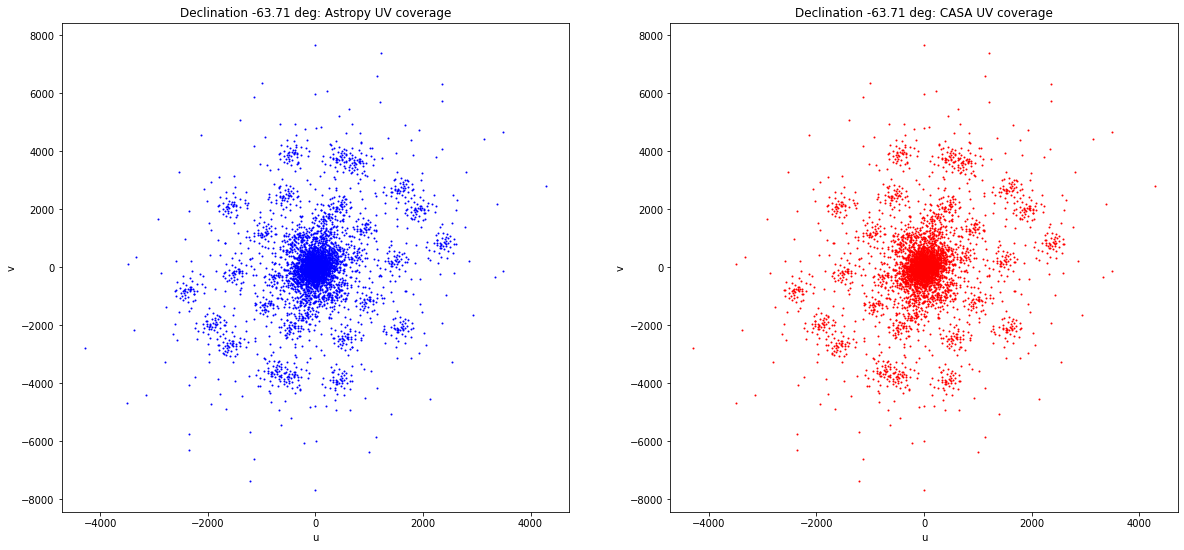

In [26]:
import matplotlib.pylab as plt
def plot_uv(bl_uvw, fig=None, ax=None, clr='b'):  # all ts per bl
    """UV coverage graph"""
    if fig is None:
        fig, ax = plt.subplots(nrows=1, ncols=1,
                               figsize=(20, 13),  # W x H
                               facecolor='white')
    ax.plot(bl_uvw[:, 0], bl_uvw[:, 1],
            color=clr,
            marker='.', markersize=2,
            linestyle='none')
    return fig, ax

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 9), facecolor='white')
axs[0].set_title(f'Declination {target.dec.degree:.2f} deg: Astropy UV coverage')
plot_uv(UVW_coverage, fig=fig, ax=axs[0], clr='b')
axs[0].set_xlabel('u')
axs[0].set_ylabel('v')

axs[1].set_title(f'Declination {target.dec.degree:.2f} deg: CASA UV coverage')
plot_uv(casa_UVW_coverage, fig=fig, ax=axs[1], clr='r')
axs[1].set_xlabel('u')
axs[1].set_ylabel('v')
plt.show()